In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [6]:
### First, estimate theta*, true causal effect of (SAT, HS GPA) on college GPA
## based on real data from 1000 students
df = pd.read_csv("clean_gpa.csv")

x_real = df[['new_sat','new_gpa']].to_numpy()
y_real = df['college_gpa'].to_numpy()

## find true causal effects theta*
# ordinary least squares (ols)
x_tilde = np.hstack((x_real,np.ones((len(x_real),1)))) # add 1 for intercept

m = x_real.shape[1]
x_sum = np.zeros([m+1,m+1])
xy_sum = np.zeros(m+1)

for i in range(len(x_real)):
  x_sum += np.outer(x_tilde[i],x_tilde[i])
  xy_sum += x_tilde[i]*y_real[i]

theta_star = np.matmul(np.linalg.inv(x_sum),xy_sum)[:-1]

# set theta* to nice values for synthetic data
# 1st entry in theta* is for SAT score, 2nd is for HSGPA
theta_star = np.array([0,0.5])

In [7]:
def test_params(num_applicants=1000, EW = np.matrix([[10.0,0],[0,1.0]]), theta_star=theta_star):
  # inputs:  num_applicants = number of applicants (time horizon T), 
  #          EW = expected effort conversion matrix E[W],
  #          theta_star = true causal effects theta* (set to [0,0.5] by default)
  #
  # output:  synthetic data for num_applicants rounds, including:
  #           z (unobserved, unmanipulated features), 
  #           x (observed, manipulated features), y (outcome), 
  #           theta (decision rule), and WWT (effort conversion matrix)
  #           
  #           estimate_list: OLS & 2SLS estimates @ rounds 10 to num_applicants
  #           error_list: L2-norm of OLS & 2SLS estimates minus true theta*
  #
  # outline: 1) create synthetic unobserved data (z_t, W_tW_t^T, g_t), 
  #             add confounding by splitting data into two types split 50/50,
  #             (1st half disadvantaged, 2nd half advantaged), 
  #             make z & WW^T worse for disadvantaged, better for advantaged
  #             & set mean g lesser for disadvantaged, high for advantaged
  #          2) set decision rule theta_t & solve for x_t and y_t based on model
  #          3) OLS estimate by regressing x onto y (w/ intercept estimate)
  #          4) 2SLS estimate by regressing x onto theta, then theta onto y (w/ intercept estimate)

  num_applicants = num_applicants
  half = int(num_applicants/2) 
  m = theta_star.size

  sigma_g = 0.1 # g variance term
  mean_sat = 900
  mean_gpa = 2
  sigma_sat = 200
  sigma_gpa = 0.5

  # initial features (z)
  z = np.zeros([num_applicants,m])

  # disadvantaged students
  z[0:half,0] = np.random.normal(mean_sat-100,sigma_sat,z[0:half,0].shape) #SAT
  z[0:half,1] = np.random.normal(mean_gpa-.2,sigma_gpa,z[0:half,1].shape) #GPA

  # advantaged students
  z[half:,0] = np.random.normal(mean_sat+100,sigma_sat,z[0:half,0].shape) #SAT
  z[half:,1] = z[half:,1] + np.random.normal(mean_gpa+.2,sigma_gpa,z[half:,1].shape) #GPA

  z[:,0] = np.clip(z[:,0],400,1600) # clip to 400 to 1600
  z[:,1] = np.clip(z[:,1],0,4) # clip to 0 to 4.0

  # confounding error term g (error on true college GPA)
  g = np.ones(num_applicants)*0.5 # legacy students shifted up
  g[0:half]=-0.5 # first-gen students shifted down
  g += np.random.normal(1,0.2,size=num_applicants) # non-zero-mean

  # assessment rule 
  
  #theta = np.zeros([num_applicants,z.shape[1]])
  #theta = np.random.normal(1,1,[num_applicants,z.shape[1]])
  #theta[:,0]*=7.5 # scaling for SAT score
  theta = np.random.multivariate_normal([1,1],[[10, 0], [0, 1]],num_applicants)

  # effort conversion matrices W_t*W_t^T
  WWT = list()

  EW = EW

  for i in range(num_applicants):
    W_t = EW.copy()

    # add noise
    noise_mean = [0.5, 0, 0, 0.1]
    noise_cov = [[0.25, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0.01]]

    noise = np.random.multivariate_normal(noise_mean, noise_cov).reshape(W_t.shape)

    if i<half: # disadvantaged
      W_t -= noise
    else: # advantaged
      W_t += noise

    WWT.append(np.matmul(W_t,W_t.T))
    #if i % 100 == 0:
    #  print(np.matmul(W_t,W_t.T))
  WWT = np.array(WWT)

  # observable features x
  x = np.zeros([num_applicants,z.shape[1]])
  for i in range(num_applicants):
    x[i] = z[i] + np.matmul(WWT[i],theta[i])
  
  x[:,0] = np.clip(x[:,0],400,1600) # clip to 400 to 1600
  x[:,1] = np.clip(x[:,1],0,4) # clip to 0 to 4.0

  # true outcomes (college gpa)
  y = np.clip(np.matmul(x,theta_star) + g,0,4) # clipped outcomes
  #y = np.matmul(x,theta_star) + g # not clipped outcomes

  '''def ols(x,y,T): # regular
    # estimate theta*: regress x onto y (with centering)
    m = x.shape[1]
    x_sum = np.zeros([m,m])
    xy_sum = np.zeros(m)

    for i in range(T):
      x_sum += np.outer(x[i],x[i])
      xy_sum += x[i]*y[i]

    return np.matmul(np.linalg.inv(x_sum),xy_sum)'''

  def ols(x,y,T): # with intercept estimation
    x_tilde = np.hstack((x,np.ones((len(x),1)))) # for parameter estimation

    m = x.shape[1]
    x_sum = np.zeros([m+1,m+1])
    xy_sum = np.zeros(m+1)

    for i in range(T):
      x_sum += np.outer(x_tilde[i],x_tilde[i])
      xy_sum += x_tilde[i]*y[i]

    theta_hat_ols = np.matmul(np.linalg.inv(x_sum),xy_sum)
    return theta_hat_ols[:m]
    
  def tsls(x,y,theta,T): # runs until round T
    theta_tilde = np.hstack((theta,np.ones((len(theta),1)))) # for parameter estimation

    m = x.shape[1]
    theta_tilde_sum = np.zeros([m+1,m+1])
    xtheta_tilde_sum = np.zeros([m+1,m])
    ytheta_tilde_sum = np.zeros(m+1)

    for i in range(T):
      theta_tilde_sum += np.outer(theta_tilde[i],theta_tilde[i])
      xtheta_tilde_sum += np.outer(theta_tilde[i],x[i])
      ytheta_tilde_sum += theta_tilde[i]*y[i]

    # Step 1) estimate Omega: regress theta onto x
    omega_hat = np.matmul(np.linalg.inv(theta_tilde_sum),xtheta_tilde_sum)
    z_bar = omega_hat[m,:]
    omega_hat = omega_hat[:m,:m] 

    # Step 2) estimate Lambda: regress theta onto y
    lambda_hat = np.matmul(np.linalg.inv(theta_tilde_sum),ytheta_tilde_sum)
    gztheta_bar = lambda_hat[m]
    lambda_hat = lambda_hat[:m]

    # Step 3) estimate theta*: inverse(Omega-hat)*Lambda-hat
    theta_hat_tsls = np.matmul(np.linalg.inv(omega_hat),lambda_hat)
    return theta_hat_tsls

  # save estimates and errors for every even round 
  estimates_list = np.zeros([int((num_applicants/2)),2,2])
  error_list = np.zeros([int((num_applicants)/2),2])
  i=0

  # shuffle the samples so types show up randomly
  [x_shuffle,y_shuffle,theta_shuffle] = [x.copy(),y.copy(),theta.copy()]
  shuffle_iter = list(range(len(x)))
  np.random.shuffle(shuffle_iter)

  j = 0
  for k in shuffle_iter:
    x_shuffle[j] = x[k]
    y_shuffle[j] = y[k]
    theta_shuffle[j] = theta[k]
    j+=1

  for t in range(10,num_applicants,2):
    # centering
    #y_mean = np.mean(y_shuffle[:t])
    #x_mean = np.mean(x_shuffle[:t],axis=0)

    # estimates
    ols_estimate = ols(x_shuffle, y_shuffle, t) # ols w/ intercept estimate
    tsls_estimate = tsls(x_shuffle, y_shuffle, theta_shuffle, t) # 2sls w/ intercept estimate
    estimates_list[i,:] += [ols_estimate,tsls_estimate]

    # errors
    ols_error = np.linalg.norm(theta_star-ols_estimate)
    tsls_error = np.linalg.norm(theta_star-tsls_estimate)
    error_list[i] = [ols_error,tsls_error]
    
    i+=1

  return [estimates_list, error_list, y, x, z, theta, WWT, EW, theta_star]

In [8]:
#@title
# set T > 10 & in units of 5s for nice plots later 
T = 5000
epochs = 10
half = int(T/2)

estimates_list_mean = np.zeros((epochs,half,2,2))
error_list_mean = np.zeros((epochs,half,2))

#estimates_list_mean = list()
#error_list_mean = list()

for i in range(epochs):
  np.random.seed(i)
  [estimates_list, error_list, y, x, z, theta, WWT, EW, theta_star] = test_params(num_applicants=T)
  estimates_list_mean[i,:] = estimates_list
  error_list_mean[i,:] = error_list

  #estimates_list_mean.append(estimates_list)
  #error_list_mean.append(error_list)

In [33]:
import pickle as pkl
import time
timestr = time.strftime('%Y%m%d-%H%H%S')
filename = 'college_admission_'+timestr
with open(filename, 'wb') as f:
    pkl.dump((estimates_list_mean, error_list_mean, y,x,z,theta,WWT,EW,theta_star), f)
# with open('college_admission_20210711-080811', 'rb') as f:
#     estimates_list_mean, error_list_mean = pkl.load(f) 

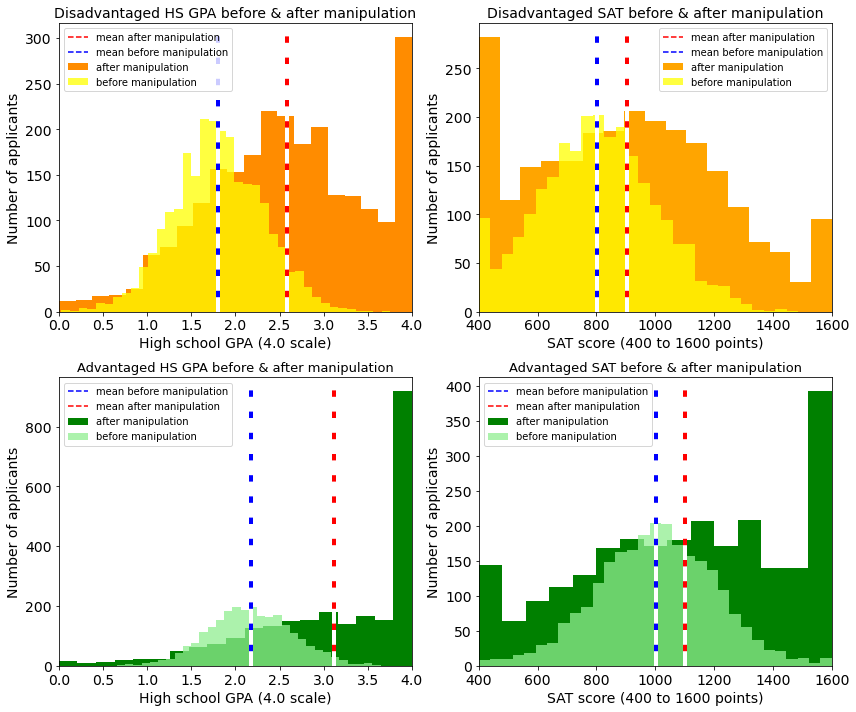

In [10]:
## plot first-gen & legacy shift unobservable features (z) to observable (x) 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12,10)) #constrained_layout=False

### first-gen HS GPA
ax1.hist(x[0:half,1],bins='auto', label='after manipulation', color='darkorange')

ax1.axvline(x=np.mean(x[0:half,1]), color='red', linestyle='--', label='mean after manipulation') # before mean
ax1.axvline(x=np.mean(x[0:half,1]), linestyle='-', color = 'red', linewidth = 4) # after mean
ax1.axvline(x=np.mean(x[0:half,1]), linestyle='--', color = 'white', linewidth = 4) # after mean

ax1.set_title("observable high school GPA (x1)")
ax1.set(ylabel='Number of applicants')

ax1.hist(z[0:half,1], bins='auto', label='before manipulation', color='yellow', alpha=0.75)
ax1.axvline(x=np.mean(z[0:half,1]), color='blue', linestyle='--', label='mean before manipulation') # before manipulation
ax1.axvline(x=np.mean(z[0:half,1]), linestyle='-', color = 'blue', linewidth = 4) # before mean
ax1.axvline(x=np.mean(z[0:half,1]), linestyle='--', color = 'white', linewidth = 4) # before mean

ax1.set_title("Disadvantaged HS GPA before & after manipulation", fontsize=14)
ax1.set_xlim(0,4)
ax1.set_xlabel('High school GPA (4.0 scale)',fontsize=14)
ax1.set_ylabel('Number of applicants',fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

ax1.legend()

### 2) first-gen SAT
ax2.hist(x[0:half,0], bins='auto', label='after manipulation', color='orange')
ax2.axvline(x=np.mean(x[0:half,0]),color='blue',)
ax2.axvline(x=np.mean(x[0:half,0]), color='red', linestyle='--', label='mean after manipulation') # after mean
ax2.axvline(x=np.mean(x[0:half,0]), linestyle='-', color = 'red', linewidth = 4) # after mean
ax2.axvline(x=np.mean(x[0:half,0]), linestyle='--', color = 'white', linewidth = 4) # after mean

ax2.set(xlabel='GPA (4.0 scale)', ylabel='Number of applicants')

ax2.hist(z[0:half,0], bins='auto', label='before manipulation', color='yellow', alpha=0.75)

ax2.axvline(x=np.mean(z[0:half,0]), color='blue', linestyle='--', label='mean before manipulation') # before mean
ax2.axvline(x=np.mean(z[0:half,0]), linestyle='-', color = 'blue', linewidth = 4) # before mean
ax2.axvline(x=np.mean(z[0:half,0]), linestyle='--', color = 'white', linewidth = 4) # before mean

ax2.set_title("Disadvantaged SAT before & after manipulation", fontsize=14)
ax2.set_xlim(400,1600)
ax2.set_xlabel('SAT score (400 to 1600 points)',fontsize=14)
ax2.set_ylabel('Number of applicants',fontsize=14)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

#ax2.legend(loc='upper left', fontsize=14)
ax2.legend()

### 3) non-first-gen HS GPA
ax3.hist(x[half:,1],bins='auto', label='after manipulation', color='green')

ax3.hist(z[half:,1], bins='auto', label='before manipulation', color='lightgreen', alpha=0.75)

ax3.axvline(x=np.mean(z[half:,1]), color='blue', linestyle='--', label='mean before manipulation') # before mean
ax3.axvline(x=np.mean(z[half:,1]), linestyle='-', color = 'blue', linewidth = 4) # before mean
ax3.axvline(x=np.mean(z[half:,1]), linestyle='--', color = 'white', linewidth = 4) # before mean

ax3.axvline(x=np.mean(x[half:,1]), color='red', linestyle='--', label='mean after manipulation') # after mean
ax3.axvline(x=np.mean(x[half:,1]), linestyle='-', color = 'red', linewidth = 4) # after mean
ax3.axvline(x=np.mean(x[half:,1]), linestyle='--', color = 'white', linewidth = 4) # after mean

ax3.set_title("Advantaged HS GPA before & after manipulation", fontsize=13)
ax3.set_xlim(0,4)
ax3.set_xlabel('High school GPA (4.0 scale)',fontsize=14)
ax3.set_ylabel('Number of applicants',fontsize=14)
ax3.tick_params(axis="x", labelsize=14)
ax3.tick_params(axis="y", labelsize=14)

ax3.legend()


### 4) non-first-gen SAT
ax4.hist(x[half:,0], bins='auto', label='after manipulation', color='green')

ax4.hist(z[half:,0], bins='auto', label='before manipulation', color='lightgreen', alpha=0.75)

ax4.axvline(x=np.mean(z[half:,0]), color='blue', linestyle='--', label='mean before manipulation') # before mean
ax4.axvline(x=np.mean(z[half:,0]), linestyle='-', color = 'blue', linewidth = 4) # before mean
ax4.axvline(x=np.mean(z[half:,0]), linestyle='--', color = 'white', linewidth = 4) # before mean

ax4.axvline(x=np.mean(x[half:,0]), color='red', linestyle='--', label='mean after manipulation') # before mean
ax4.axvline(x=np.mean(x[half:,0]), linestyle='-', color = 'red', linewidth = 4) # before mean
ax4.axvline(x=np.mean(x[half:,0]), linestyle='--', color = 'white', linewidth = 4) # before mean

ax4.set_title("Advantaged SAT before & after manipulation", fontsize=13)
ax4.set_xlim(400,1600)
ax4.set_xlabel('SAT score (400 to 1600 points)',fontsize=14)
ax4.set_ylabel('Number of applicants',fontsize=14)
ax4.tick_params(axis="x", labelsize=14)
ax4.tick_params(axis="y", labelsize=14)

#ax4.legend(bbox_to_anchor=(-3, 0), loc='upper left', fontsize=14,ncol=4)
ax4.legend()

## legend
pre_fg = Patch(color='yellow', label='disadvantaged unobserved (unmanipulated)', alpha=0.75)
post_fg = Patch(color='darkorange', label='disadvantaged observed (manipulated)')

pre_ls = Patch(color='lightgreen', label='legacy unobserved (unmanipulated)', alpha=0.75)
post_ls = Patch(color='green', label='legacy observed (manipulated)')

before_mean = Line2D([0], [0], color='blue', linestyle='--', lw=2, label='mean before manipulation')
after_mean = Line2D([0], [0], color='red', linestyle='--', lw=2, label='mean after manipulation')

fig.tight_layout()

plt.savefig('fg-ls_shifted_features.png', dpi=500)
plt.show()

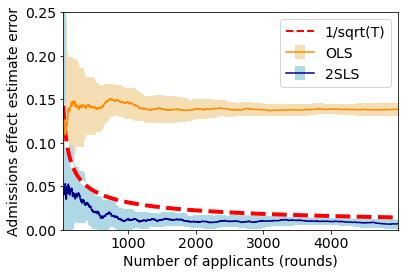

In [11]:
# vars for pyplot
ticks = list(range(int(T/5), T+1, int(T/5)))
ticks.insert(0,1)

# plot error of OLS vs 2SLS with error bar
plt.errorbar(list(range(2,T+1,2)), np.mean(error_list_mean,axis=0)[:,0], yerr=np.std(error_list_mean,axis=0)[:,0], 
             color='darkorange', ecolor='wheat', label='OLS',elinewidth=10)
plt.errorbar(list(range(2,T+1,2)), np.mean(error_list_mean,axis=0)[:,1], yerr=np.std(error_list_mean,axis=0)[:,1], 
             color='darkblue', ecolor='lightblue', label='2SLS',elinewidth=10)
plt.ylim(0,.25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(50,T-11)

plt.xlabel('Number of applicants (rounds)', fontsize=14)
plt.ylabel('Admissions effect estimate error', fontsize=14)

plt.plot(range(1,T+1), 1/np.sqrt(range(1,T+1)), color='red',linestyle='dashed', linewidth=2, label='1/sqrt(T)')
plt.plot(range(1,T+1), 1/np.sqrt(range(1,T+1)), linestyle='-', color = 'white', linewidth = 4)
plt.plot(range(1,T+1), 1/np.sqrt(range(1,T+1)), linestyle='--', color = 'red', linewidth = 4)

plt.legend(fontsize=14)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
#plt.title("Estimation error over rounds for OLS vs 2SLS")

plt.savefig('error_estimation.png', dpi=500, bbox_inches='tight')
plt.show()

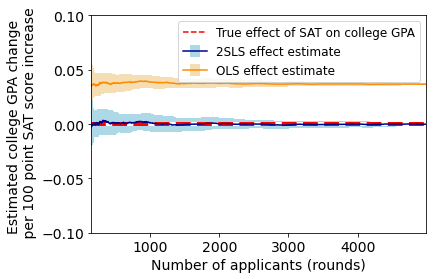

In [12]:
# plot causal effect estimates --OLS vs 2SLS vs theta*
temp = 100*estimates_list_mean
tsls_mean = np.mean(temp,axis=0)[:,1,0]
ols_mean = np.mean(temp,axis=0)[:,0,0]
tsls_std = np.std(temp,axis=0)[:,1,0]
ols_std = np.std(temp,axis=0)[:,0,0]

plt.errorbar(list(range(2,T+1,2)), tsls_mean, yerr=tsls_std, color='darkblue', ecolor='lightblue', label='2SLS effect estimate',elinewidth=10)
plt.errorbar(list(range(2,T+1,2)), ols_mean, yerr=ols_std, color='darkorange', ecolor='wheat', label='OLS effect estimate',elinewidth=10)
plt.axhline(theta_star[0],label='True effect of SAT on college GPA', color='red',linestyle='dashed')
plt.axhline(theta_star[0], linestyle='-', color = 'white', linewidth = 4)
plt.axhline(theta_star[0], linestyle='--', color = 'red', linewidth = 4)

#plt.set_title("Estimated SAT effect estimation")
plt.xlabel('Number of applicants (rounds)',fontsize=14)
plt.ylabel('Estimated college GPA change \n per 100 point SAT score increase',fontsize=14)
plt.xlim(150,T-11)
plt.xticks(fontsize=14)
plt.yticks(np.arange(-1,1,step=0.05), fontsize=14)
# plt.ylim(-.2,0.4)
plt.ylim(-0.1,0.1)

plt.legend(fontsize=12)

plt.savefig('estimate_convergence.png', dpi=500, bbox_inches='tight')
plt.show()

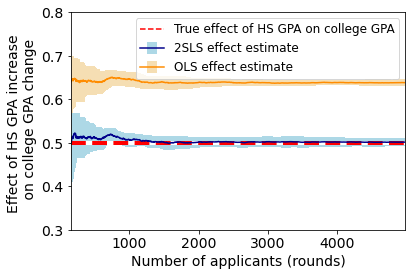

In [32]:
# plot causal effect estimates --OLS vs 2SLS vs theta*
temp = estimates_list_mean
tsls_mean = np.mean(temp,axis=0)[:,1,1]
ols_mean = np.mean(temp,axis=0)[:,0,1]
tsls_std = np.std(temp,axis=0)[:,1,1]
ols_std = np.std(temp,axis=0)[:,0,1]

plt.errorbar(list(range(2,T+1,2)), tsls_mean, yerr=tsls_std, color='darkblue', ecolor='lightblue', label='2SLS effect estimate',elinewidth=10)
plt.errorbar(list(range(2,T+1,2)), ols_mean, yerr=ols_std, color='darkorange', ecolor='wheat', label='OLS effect estimate',elinewidth=10)
plt.axhline(theta_star[1],label='True effect of HS GPA on college GPA', color='red',linestyle='dashed')
plt.axhline(theta_star[1], linestyle='-', color = 'white', linewidth = 4)
plt.axhline(theta_star[1], linestyle='--', color = 'red', linewidth = 4)

#plt.set_title("Estimated SAT effect estimation")
plt.xlabel('Number of applicants (rounds)',fontsize=14)
plt.ylabel('Effect of HS GPA increase \n on college GPA change',fontsize=14)
plt.xlim(150,T-11)
plt.xticks(fontsize=14)
plt.yticks(np.arange(-1,1,step=0.1), fontsize=14)
# plt.ylim(-.2,0.4)
plt.ylim(0.3,0.8)

plt.legend(fontsize=12, loc='upper right')

plt.savefig('estimate_convergence-HS-GPA.png', dpi=500, bbox_inches='tight')
plt.show()

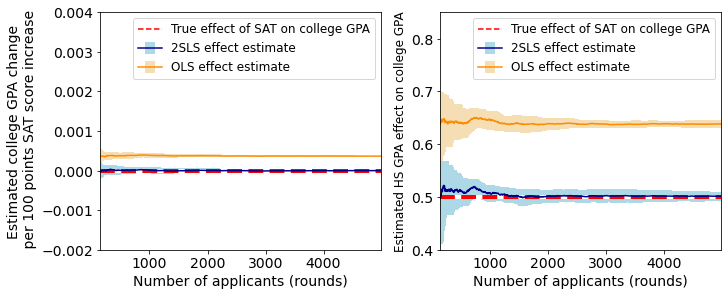

In [21]:
# plot causal effect estimates --OLS vs 2SLS vs theta*
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4),constrained_layout=True)
ax1.errorbar(list(range(2,T+1,2)), np.mean(estimates_list_mean,axis=0)[:,1,0], yerr=np.std(estimates_list_mean,axis=0)[:,1,0], 
             color='darkblue', ecolor='lightblue', label='2SLS effect estimate',elinewidth=10)
ax1.errorbar(list(range(2,T+1,2)), np.mean(estimates_list_mean,axis=0)[:,0,0], yerr=np.std(estimates_list_mean,axis=0)[:,0,0], 
             color='darkorange', ecolor='wheat', label='OLS effect estimate',elinewidth=10)
ax1.axhline(theta_star[0],label='True effect of SAT on college GPA', color='red',linestyle='dashed')
ax1.axhline(theta_star[0], linestyle='-', color = 'white', linewidth = 4)
ax1.axhline(theta_star[0], linestyle='--', color = 'red', linewidth = 4)

#ax1.set_title("Estimated SAT effect estimation")
ax1.set_xlabel('Number of applicants (rounds)',fontsize=14)
# ax1.set_ylabel('Estimated HS GPA effect on college GPA',fontsize=14)
ax1.set_ylabel('Estimated college GPA change\n per 100 points SAT score increase', fontsize=14)
ax1.set_xlim(150,T-11)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
ax1.set_ylim(-.002,0.004)

ax1.legend(fontsize=12)

ax2.errorbar(list(range(2,T+1,2)), np.mean(estimates_list_mean,axis=0)[:,1,1], yerr=np.std(estimates_list_mean,axis=0)[:,1,1], 
             color='darkblue', ecolor='lightblue', label='2SLS effect estimate',elinewidth=10)
ax2.errorbar(list(range(2,T+1,2)), np.mean(estimates_list_mean,axis=0)[:,0,1], yerr=np.std(estimates_list_mean,axis=0)[:,0,1], 
             color='darkorange', ecolor='wheat', label='OLS effect estimate',elinewidth=10)

ax2.axhline(theta_star[1],label='True effect of SAT on college GPA', color='red',linestyle='dashed')
ax2.axhline(theta_star[1], linestyle='-', color = 'white', linewidth = 4)
ax2.axhline(theta_star[1], linestyle='--', color = 'red', linewidth = 4)

#ax2.set_title("Estimated HS GPA effect estimation")
ax2.set_xlabel('Number of applicants (rounds)',fontsize=14)
ax2.set_ylabel('Estimated HS GPA effect on college GPA',fontsize=12)
ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)
ax2.set_xlim(150,T-11)
ax2.set_ylim(.4,.85)

ax2.legend(fontsize=12)

plt.savefig('estimate_convergence.png', dpi=500, bbox_inches='tight')
plt.show()

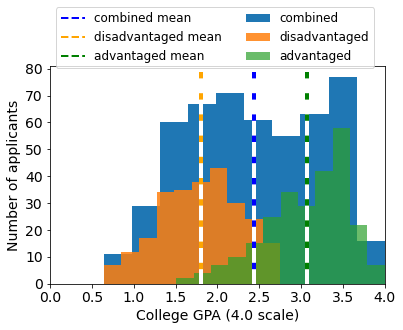

In [9]:
#@title  { form-width: "20%" }
## plot college gpa (outcome y)
# combined
plt.hist(y,bins='auto',label='combined')
plt.axvline(x=np.mean(y),color='blue',linestyle='--', linewidth = 2, label='combined mean')
plt.axvline(x=np.mean(y), linestyle='-', color = 'blue', linewidth = 4)
plt.axvline(x=np.mean(y), linestyle='--', color = 'white', linewidth = 4)

# disadvantaged
plt.hist(y[0:half],bins='auto',label='disadvantaged', alpha=.85)
plt.axvline(x=np.mean(y[0:half]),color='orange',linestyle='--', linewidth = 2, label='disadvantaged mean')
plt.axvline(x=np.mean(y[0:half]), linestyle='-', color = 'orange', linewidth = 4)
plt.axvline(x=np.mean(y[0:half]), linestyle='--', color = 'white', linewidth = 4)

# advantaged
plt.hist(y[half:],bins='auto',label='advantaged', alpha=0.7)
plt.axvline(x=np.mean(y[half:]), linestyle='--', color = 'green', linewidth = 2, label='advantaged mean')
plt.axvline(x=np.mean(y[half:]),color='green',linestyle='-', linewidth = 4)
plt.axvline(x=np.mean(y[half:]), linestyle='--', color = 'white', linewidth = 4)

plt.xlim(0,4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('College GPA (4.0 scale)', fontsize=14)
plt.ylabel('Number of applicants', fontsize=14)

#plt.title("True college GPA (y) for disadvantaged vs. advantaged students")

plt.legend(bbox_to_anchor=(0, 1.3), loc='upper left', fontsize=12, ncol=2)

plt.savefig('all_outcome.png', dpi=500, bbox_inches='tight')
plt.show()

In [35]:
# save to file
estimates_list.tofile("saved_estimates_list")
error_list.tofile("saved_error_list")
y.tofile("saved_y_list")
x.tofile("saved_x_list")
z.tofile("saved_z_list")
np.array(WWT).tofile("saved_WWT_list")
# EWWT.tofile("saved_EWWT")
theta_star.tofile("saved_theta_star")
estimates_list_mean.tofile("saved_estimates_list_mean")
error_list_mean.tofile("saved_error_list_mean")